# Implementation of Friedman's GBM with Custom Objective

In this notebook, I figure out the hacks needed to implement Friedman's original GBM algorithm using sklearn DecisionTreeRegressor as the weak learner and scipy minimize as the argmin method.
Basically we just need to be able to modify the tree predictions to predict the best prediction value according to the argmin of the loss function.
This page on the [decision tree structure](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html)  in the sklearn documentation is super helpful.

## sklearn decision trees

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

## Prepare the data ##

In [80]:
rng = np.random.default_rng()
x = np.linspace(0, 10, 200)
y = np.where(x < 5, x, 5) + rng.normal(0, 0.4, size=x.shape)
x = x.reshape(-1,1)

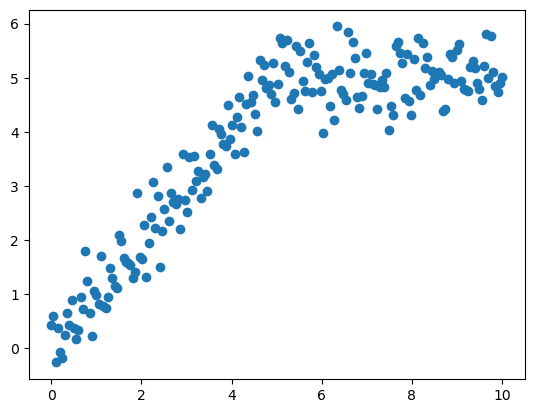

In [81]:
plt.plot(x, y, 'o')

## Friedman's Generic Gradient Boosting Algorithm ##  
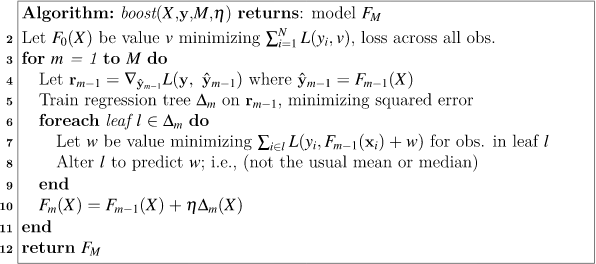

## 简单的GMB ##

In [82]:
class GradientBoostingFromScratch():
    
    def __init__(self, n_trees, learning_rate, max_depth=1):
        self.n_trees=n_trees; self.learning_rate=learning_rate; self.max_depth=max_depth;
        
    def fit(self, x, y):
        self.trees = []
        # set the F0(x)
        self.F0 = y.mean()
        Fm = self.F0 
        for _ in range(self.n_trees):
            #set up regression tree 
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            #residual = y - Fm for training
            tree.fit(x, y - Fm)  
            # the tree.predict(x) = w = mean of y - y_hat 
            Fm += self.learning_rate * tree.predict(x) 
            self.trees.append(tree)
            
    def predict(self, x):
        return self.F0 + self.learning_rate * np.sum([tree.predict(x) for tree in self.trees], axis=0)

In [83]:
from sklearn.tree import DecisionTreeRegressor

# model hyperparameters
learning_rate = 0.3
n_trees = 10
max_depth = 2

# Training
F0 = y.mean() 
Fm = F0
trees = []
for _ in range(n_trees):
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree.fit(x, y - Fm)
    Fm += learning_rate * tree.predict(x)
    trees.append(tree)

# Prediction
y_hat = F0 + learning_rate * np.sum([t.predict(x) for t in trees], axis=0)

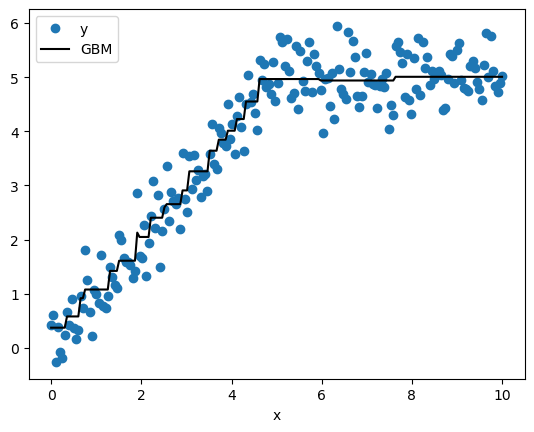

In [84]:
#hide_input
plt.plot(x,y,'o', label='y')
plt.plot(x,y_hat,'-k', label='GBM')
plt.legend()
plt.xlabel('x');

In [85]:
reg = DecisionTreeRegressor(max_depth=2)
reg.fit(x, y)
y_hat = reg.predict(x)

In [86]:
# parallel arrays that give info on the nodes
pd.DataFrame({
    'children_left': reg.tree_.children_left
    , 'children_right': reg.tree_.children_right
    , 'feature': reg.tree_.feature 
    , 'threshold': reg.tree_.threshold
    , 'n_node_samples': reg.tree_.n_node_samples 
    , 'impurity': reg.tree_.impurity
})

,children_left,children_right,feature,threshold,n_node_samples,impurity
0,1,4,0,3.492462,200,2.842706
1,2,3,0,1.884422,70,1.097194
2,-1,-1,-2,-2.000000,38,0.359338
3,-1,-1,-2,-2.000000,32,0.348038
4,5,6,0,4.296482,130,0.300465
5,-1,-1,-2,-2.000000,16,0.133329
6,-1,-1,-2,-2.000000,114,0.180591


The index corresponds to the nodes in the tree.
`children_left` and `children_right` give the index of the left and right children of the given node. 
They are set to -1 on the terminal nodes.
Looks like the tree is indexed in a depth-first order.

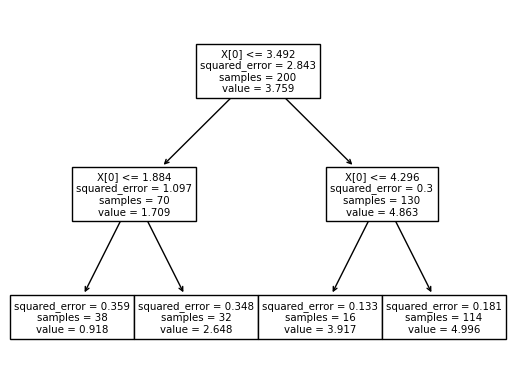

In [87]:
plot_tree(reg);

In [88]:
reg.tree_.node_count

7

In [89]:
# find the terminal nodes that each observation lands in.
reg.apply(x)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6])

In [90]:
# find the terminal nodes that each observation lands in.
# it works on the tree_ object too
reg.tree_.apply(x.astype(np.float32))

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6])

In [91]:
# terminal node id's
np.nonzero(reg.tree_.children_left == reg.tree_.children_right)[0]

array([2, 3, 5, 6])

In [92]:
# the prediction values for each node (including non terminal ones)
reg.tree_.value

array([[[3.75928113]],

       [[1.7090544 ]],

       [[0.91804084]],

       [[2.648383  ]],

       [[4.86324936]],

       [[3.91691426]],

       [[4.99606833]]])

Not sure why `value` has two other dimensions.

In [93]:
# the prediction values for each node (including non terminal ones)
reg.tree_.value[:, 0, 0]

array([3.75928113, 1.7090544 , 0.91804084, 2.648383  , 4.86324936,
       3.91691426, 4.99606833])

In [94]:
# manually get predicted values for given feature vector observations
reg.tree_.value[:, 0, 0][reg.apply(x)]

array([0.91804084, 0.91804084, 0.91804084, 0.91804084, 0.91804084,
       0.91804084, 0.91804084, 0.91804084, 0.91804084, 0.91804084,
       0.91804084, 0.91804084, 0.91804084, 0.91804084, 0.91804084,
       0.91804084, 0.91804084, 0.91804084, 0.91804084, 0.91804084,
       0.91804084, 0.91804084, 0.91804084, 0.91804084, 0.91804084,
       0.91804084, 0.91804084, 0.91804084, 0.91804084, 0.91804084,
       0.91804084, 0.91804084, 0.91804084, 0.91804084, 0.91804084,
       0.91804084, 0.91804084, 0.91804084, 2.648383  , 2.648383  ,
       2.648383  , 2.648383  , 2.648383  , 2.648383  , 2.648383  ,
       2.648383  , 2.648383  , 2.648383  , 2.648383  , 2.648383  ,
       2.648383  , 2.648383  , 2.648383  , 2.648383  , 2.648383  ,
       2.648383  , 2.648383  , 2.648383  , 2.648383  , 2.648383  ,
       2.648383  , 2.648383  , 2.648383  , 2.648383  , 2.648383  ,
       2.648383  , 2.648383  , 2.648383  , 2.648383  , 2.648383  ,
       3.91691426, 3.91691426, 3.91691426, 3.91691426, 3.91691

In [95]:
# modifying one of the terminal node prediction values
reg.tree_.value[3, 0, 0] = 0.0

In [96]:
#built in predict method
reg.predict(x)

array([0.91804084, 0.91804084, 0.91804084, 0.91804084, 0.91804084,
       0.91804084, 0.91804084, 0.91804084, 0.91804084, 0.91804084,
       0.91804084, 0.91804084, 0.91804084, 0.91804084, 0.91804084,
       0.91804084, 0.91804084, 0.91804084, 0.91804084, 0.91804084,
       0.91804084, 0.91804084, 0.91804084, 0.91804084, 0.91804084,
       0.91804084, 0.91804084, 0.91804084, 0.91804084, 0.91804084,
       0.91804084, 0.91804084, 0.91804084, 0.91804084, 0.91804084,
       0.91804084, 0.91804084, 0.91804084, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       3.91691426, 3.91691426, 3.91691426, 3.91691426, 3.91691

## scipy minimize

In [97]:
from scipy.optimize import minimize

In [98]:
my_fun = lambda t: (t - 4)**2 + 3
t0 = 0
res = minimize(my_fun, t0)
res.x[0]

3.999999987147814

In [109]:
res

      fun: 3.0
 hess_inv: array([[0.5]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([3.99999999])

That wasn't so bad.

## Loss Function Classes

I think we'll implement loss functions as a class that the user supplies.
The class should have two methods, `loss` and `negative_gradient`, which both take two arguments, `y` and `y_hat`.
The `loss` method should return a scalar, while the `negative_gradient` method should return an array the same size as `y` and `y_hat`.

In [99]:
class SquaredErrorLoss():
    
    def loss(self, y, y_hat):
        return np.mean((y - y_hat)**2)
    
    def negative_gradient(self, y, y_hat):
        return y - y_hat

In [100]:
# make an instance
obj = SquaredErrorLoss()

In [101]:
# loss method should return a number
obj.loss(y, y_hat)

0.23756349425442555

In [102]:
# negative_gradient method should return an array, same shape as y and y_hat (get from previouse one dicision tree)
obj.negative_gradient(y, y_hat)

array([-0.49255678, -0.32066061, -1.1784309 , -0.53375033, -0.98815151,
       -1.09888638, -0.67857424, -0.25830859, -0.49204353, -0.02359868,
       -0.54589252, -0.75128065, -0.58031253,  0.03874785, -0.19066955,
        0.88048938,  0.32790997, -0.26344076, -0.69209517,  0.14841553,
        0.07083979, -0.09176096,  0.79218655, -0.13984208, -0.17380496,
        0.03267205,  0.57492123,  0.38596099,  0.23825812,  0.19322872,
        1.17191446,  1.06500213,  0.74360901,  0.67556879,  0.66238355,
        0.61572065,  0.37655057,  0.49968143,  0.22022114, -0.95836931,
       -0.9939993 , -0.37475115, -1.32978096, -0.70896935, -0.21635722,
        0.4337836 , -0.42981613,  0.17449931, -1.15174471, -0.48872236,
       -0.08142043,  0.70285175, -0.30088331,  0.22241331,  0.06431568,
        0.01334207,  0.11388726, -0.45009487,  0.94884203,  0.0932048 ,
       -0.13219572,  0.88661359,  0.28153107,  0.91233939,  0.4425616 ,
        0.63421352,  0.13398699,  0.5170198 ,  0.56861933,  0.25

## GBM Implementation

In [160]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor 
from scipy.optimize import minimize

class GradientBoostingMachine():
    '''Gradient Boosting Machine supporting any user-supplied loss function.
    
    Parameters
    ----------
    n_trees : int
        number of boosting rounds
        
    learning_rate : float
        learning rate hyperparameter
        
    max_depth : int
        maximum tree depth
    '''
    
    def __init__(self, n_trees, learning_rate=0.1, max_depth=1):
        self.n_trees=n_trees; 
        self.learning_rate=learning_rate
        self.max_depth=max_depth;
    
    def fit(self, X, y, objective):
        '''Fit the GBM using the specified loss function.
        
        Parameters
        ----------
        X : ndarray of size (number observations, number features)
            design matrix
            
        y : ndarray of size (number observations,)
            target values
            
        objective : loss function class instance
            Class specifying the loss function for training.
            Should implement two methods:
                loss(labels: ndarray, predictions: ndarray) -> float
                negative_gradient(labels: ndarray, predictions: ndarray) -> ndarray
        '''
        
        self.trees = []
        # initial the F0
        self.base_prediction = self._get_optimal_base_value(y, objective.loss)
        # convert to matrix
        current_predictions = self.base_prediction * np.ones(shape=y.shape)
        # start to run boosting
        for _ in range(self.n_trees):
            
            # using object function return the residual = negative gradient (partial deritive of the loss function) 
            pseudo_residuals = objective.negative_gradient(y, current_predictions)
            # here setup the tree still with MSE
            tree = DecisionTreeRegressor(max_depth=self.max_depth) 
            
            #using redidual to train the tree and get the predicted (minimized) delta
            tree.fit(X, pseudo_residuals)
            
            # replace orignal loss with the object function loss/residual or target
            self._update_terminal_nodes(tree, X, y, current_predictions, objective.loss)
            
            #adding the delta part into whole function y
            current_predictions += self.learning_rate * tree.predict(X)
            self.trees.append(tree)
     
    #get the intial value (F0) to minimize the all data loss
    def _get_optimal_base_value(self, y, loss):
        '''Find the optimal initial prediction for the base model.'''
        fun = lambda c: loss(y, c)
        c0 = y.mean() # give the initial value as mean of the data
        return minimize(fun=fun, x0=c0).x[0]
        
    def _update_terminal_nodes(self, tree, X, y, current_predictions, loss):
        '''Update the tree's predictions according to the loss function.'''
        # terminal node id's
        leaf_nodes = np.nonzero(tree.tree_.children_left == -1)[0]
        # compute leaf for each sample in ``X``.
        leaf_node_for_each_sample = tree.apply(X)
        for leaf in leaf_nodes:
            samples_in_this_leaf = np.where(leaf_node_for_each_sample == leaf)[0]
            y_in_leaf = y.take(samples_in_this_leaf, axis=0)
            preds_in_leaf = current_predictions.take(samples_in_this_leaf, axis=0)
            # get the predict value w
            val = self._get_optimal_leaf_value(y_in_leaf, 
                                               preds_in_leaf,
                                               loss)
            tree.tree_.value[leaf, 0, 0] = val
            
    #get the optimized loss target to the  w/c or residual: y-(current_preddiction+w) = (y-current_predictin) -w 
    # = residual - w ..
    def _get_optimal_leaf_value(self, y, current_predictions, loss):
        '''Find the optimal prediction value for a given leaf.'''
        fun = lambda c: loss(y, current_predictions + c)
        c0 = y.mean()       
        return minimize(fun=fun, x0=c0).x[0]
          
    def predict(self, X):
        '''Generate predictions for the given input data.'''
        return (self.base_prediction 
                + self.learning_rate 
                * np.sum([tree.predict(X) for tree in self.trees], axis=0))

### Mean Squared Error

In [119]:
rng = np.random.default_rng()
x = np.linspace(0, 10, 500)
y = np.where(x < 5, x, 5) + rng.normal(0, 0.4, size=x.shape)
x = x.reshape(-1,1)

In [120]:
class SquaredErrorLoss():
    
    def loss(self, y, y_hat):
        return np.mean((y - y_hat)**2)
    
    def negative_gradient(self, y, y_hat):
        return y - y_hat

In [161]:
gbm = GradientBoostingMachine(n_trees=10,
                              learning_rate=0.5)
gbm.fit(x, y, SquaredErrorLoss())

Text(0.5, 1.0, 'model predicting mean or y | x')

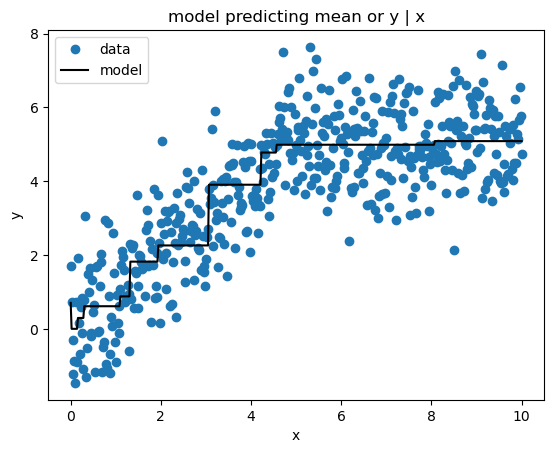

In [162]:
# fig, ax = plt.subplot()
plt.plot(x.ravel(), y, 'o', label='data')
plt.plot(x.ravel(), gbm.predict(x), '-k', label='model')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('model predicting mean or y | x')

### Mean Absolute Error

In [123]:
rng = np.random.default_rng()
x = np.linspace(0, 10, 500)
y = np.where(x < 5, x, 5) + rng.normal(0, 0.4, size=x.shape)
x = x.reshape(-1,1)

In [124]:
class AbsoluteErrorLoss():
    
    def loss(self, y, y_hat):
        return np.mean(np.abs(y - y_hat))
    
    def negative_gradient(self, y, y_hat):
        return np.sign(y - y_hat)

In [125]:
gbm = GradientBoostingMachine(n_trees=10,
                              learning_rate=0.5)
gbm.fit(x, y, AbsoluteErrorLoss())

Text(0.5, 1.0, 'model predicting median of y | x')

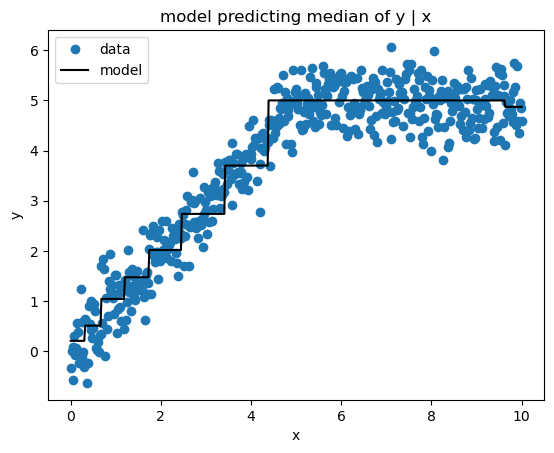

In [126]:
# fig, ax = plt.subplot()
plt.plot(x.ravel(), y, 'o', label='data')
plt.plot(x.ravel(), gbm.predict(x), '-k', label='model')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('model predicting median of y | x')

### Quantile Loss
$$
L_\gamma\left(y, y^p\right)=\sum_{i: y_i<y_i^p}(1-\gamma)\left|y_i-y_i^p\right|+\sum_{i: y_i \geq y_i^p} \gamma\left|y_i-y_i^p\right|
$$
γ是所需的分位数，其值介于0和1之间。 Y轴：分位数损失。X轴：预测值。Y的真值为0。
许多商业问题的决策通常希望了解预测中的不确定性，更关注区间预测而不仅是点预测时，分位数损失函数就很有用。

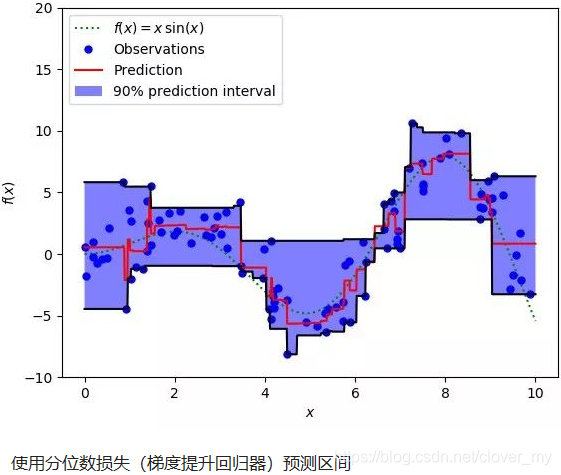

In [131]:
rng = np.random.default_rng()
x = np.linspace(0, 10, 500)
# y = np.where(x < 5, x, 5) + rng.uniform(-2, 2, size=x.shape)
y = np.where(x < 5, x, 5) + rng.normal(0, 1, size=x.shape)
x = x.reshape(-1,1)

In [132]:
class QuantileLoss():
    
    def __init__(self, alpha):
        if alpha < 0 or alpha >1:
            raise ValueError('alpha must be between 0 and 1')
        self.alpha = alpha
        
    def loss(self, y, y_hat):
        e = y - y_hat
        return np.mean(np.where(e > 0, self.alpha * e, (self.alpha - 1) * e))
    
    def negative_gradient(self, y, y_hat):
        e = y - y_hat 
        return np.where(e > 0, self.alpha, self.alpha - 1)

In [163]:
gbm_up = GradientBoostingMachine(n_trees=10,
                              learning_rate=0.5)
gbm_up.fit(x, y, QuantileLoss(alpha=0.9))

gbm_low = GradientBoostingMachine(n_trees=10,
                              learning_rate=0.5)

gbm_low.fit(x, y, QuantileLoss(alpha=0.05))

Text(0.5, 1.0, 'model predicting 0.9 quantile of y | x')

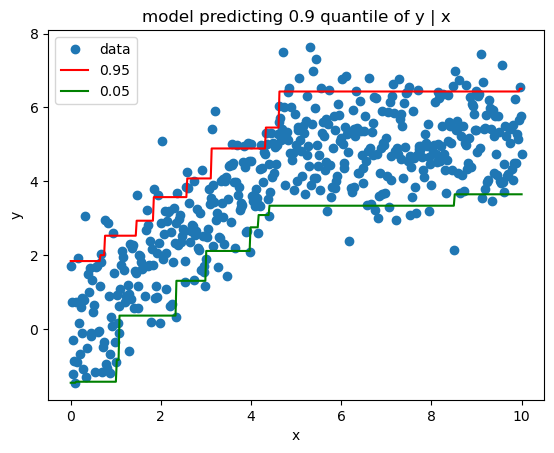

In [167]:
plt.plot(x, y, 'o', label='data')
plt.plot(x, gbm_up.predict(x), 'r-', label='0.95')
plt.plot(x, gbm_low.predict(x), 'g-', label='0.05')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('model predicting 0.9 quantile of y | x')

### Binary Cross Entropy

In [168]:
rng = np.random.default_rng()
x = np.linspace(-3, 3, 500)
expit = lambda t: np.exp(t) / (1 + np.exp(t))
p = expit(x)
y = rng.binomial(1, p, size=p.shape)
x = x.reshape(-1,1)

In [169]:
class BinaryCrossEntropyLoss():
    # in these methods, y_hat gives the log odds ratio
    
    def __init__(self):
        self.expit = lambda t: np.exp(t) / (1 + np.exp(t))
    
    def loss(self, y, y_hat):
        p = self.expit(y_hat)
        return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
    
    def negative_gradient(self, y, y_hat):
        p = self.expit(y_hat)
        return y / p - (1 - y) / (1 - p)

In [170]:
gbm = GradientBoostingMachine(n_trees=10,
                              learning_rate=0.5)
gbm.fit(x, y, BinaryCrossEntropyLoss())

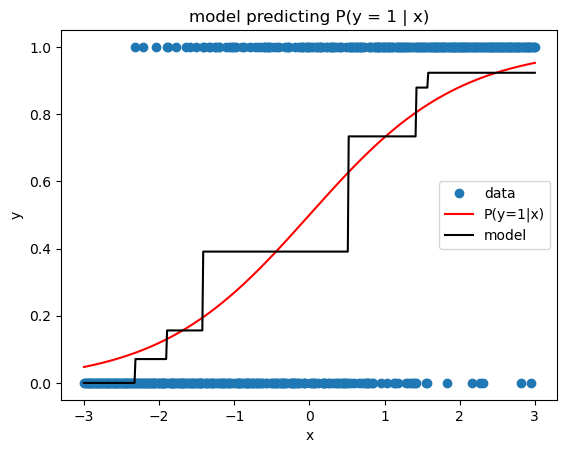

In [171]:
plt.plot(x, y, 'o', label='data')
plt.plot(x, p, '-r', label='P(y=1|x)')
plt.plot(x, expit(gbm.predict(x)), '-k', label='model')
plt.title('model predicting P(y = 1 | x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()